# After Titanic EDA

## Predictive Modeling
* Classification Algorithms를 활용하여 탑승자의 생존 여부를 파악해 볼 것이다.
* 모델을 만드는데 있어 사용해볼 알고리즘
    * Logistic Regression
    * Support Vector Machines(linear and radial)
    * Random Forest
    * K-Nearest Neighbours
    * Naive Bayes
    * Decision Tree
    * Logistic Regression

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
data=pd.read_csv('/kaggle/input/titanic/train.csv')

In [5]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

# Feature Engineering and Data Cleaning
* 해당 파트는 추후 공부이후에 재업로드 할 예정
* 현재 코드는 https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook 참조.

In [7]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [8]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [9]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [10]:
data.Age.isnull().any()

False

In [11]:
data['Embarked'].fillna('S',inplace=True)

In [12]:
data.Embarked.isnull().any()# Finally No NaN values

False

In [13]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [14]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone


In [15]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

In [16]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [18]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [19]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

In [20]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)

# Radial Support Vector Machines(rbf-SVM)
* 가장 흔하게 사용되는 SVM kernel로, kernel 옵션을 따로 "linear", "poly"로 명시하지 않는다면 자동으로 "rbf"로 설정된다.
* rbf커널이 데이터 포인트를 어떻게 transform 하는지를 시각화 하는 것은 꽤 복잡하다.
* 간단히 표현하면 rbf kernel은 2차원 데이터를 무한한 차원의 공간상으로 변형
* rbf커널의 gamma 파라미터에 대한 이해는 필요하므로 짚고 넘어가자
* gamma: C 파라미터와 비슷, gamma값이 크면 training 데이터에 더 많은 중요도를 부여하므로서 overfitting될 수 있고, 반대로 gamma값이 작으면 데이터에 중요도를 덜 부여함으로써 underfitting될 수 있음

In [21]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

In [22]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


# Linear Support Vector Machine(linear-SVM)
* 선형 분리가 가능한 데이터에서 사용
* 즉, decision boundary를 직선으로 나타낼 수 있을 때 사용

In [23]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


# Logistic Regression
* 종속 변수와 독립 변수간의 관계를 구체적인 함수로 나타내어 향후 예측 모델에 사용
* 독립 변수의 선형 결합으로 종속 변수를 설명한다는 관점에서 선형 회귀 분석과 유사
* 선형 회귀 분석과의 차이점은 종속 변수가 범주형 데이터를 대상으로 하고, 입력 데이터가 주어졌을 때 해당 데이터의 결과가 특정 분류로 나뉘기 때문에 일종의 분류(classification) 기법으로 볼 수 있음
* 로지스틱 회귀는 타이타닉 데이터셋과 같은 binary classification에서 흔히 사용

In [24]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


# Decision Tree

In [25]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8059701492537313


# K-Nearest Neighbours(KNN)

In [26]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.8134328358208955


K 근접 이웃 알고리즘은 n_neighbours 파라미터의 값에 따라 정확도가 변화한다.(default = 5)
n_neighbours의 변화에 따른 정확도의 차이를 구해보자

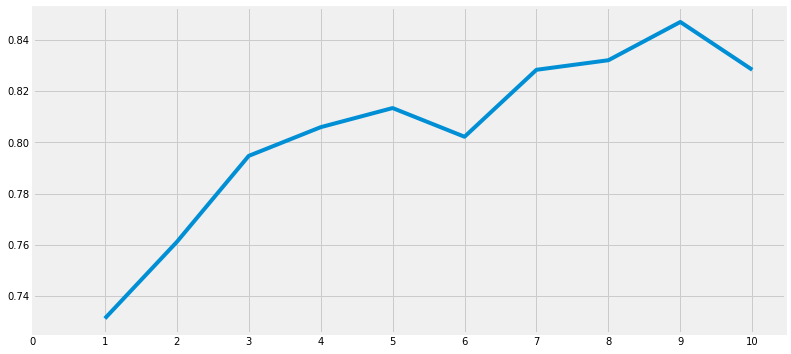

Accuracies for different values of n are: [0.73134328 0.76119403 0.79477612 0.80597015 0.81343284 0.80223881
 0.82835821 0.83208955 0.84701493 0.82835821] with the max value as  0.8470149253731343


In [27]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

# Gaussian Naive Bayes
* 해당 분류기의 학습에 앞서 베이즈 정리에 대하여 학습하였다.
* 표본 평균과 표본 분산을 가진 정규 분포 하에서 베이즈 정리를 사용한 것
* 각 클래스의 연속적인 값들이 가우스 분포를 따른다고 가정


#### Naive Bayse
https://en.wikipedia.org/wiki/Naive_Bayes_classifier

In [28]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


# Random Forests
* Decision Tree의 Overfitting 가능성이 높은 문제점의 해결방안
* 여러개의 decision tree를 생성하고 새로운 데이터 포인트를 각 트리에 동시에 통과시켜 가장 많이 득표한 결과를 최종 분류 결과로 선택

In [29]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8246268656716418


# 요약
* 여러가지 분류기를 통해 모델의 정확도를 평가해 보았다.
* 대부분 80% 이상의 정확도를 보여주었으나 새로운 데이터에 대한 정확도는 아직 알 수 없다.
* 이를 극복하기 위해 Cross Validation과정을 다음으로 수행해보고자 한다.